In [1]:
import collections
import json
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

# Data Imports

In [2]:
with open("data/results/all__daily_post_stats.json") as handle:
    daily_post_count = json.load(handle)
    
with open("data/results/posts_to_libs.json") as handle:
    data = json.load(handle)

with open("data/results/ip__libs_count.json") as handle:
    libs_count = json.load(handle)
with open("data/results/ip__pairs_count.json") as handle:
    pairs_count = json.load(handle)
    
with open("data/results/ip__all_libs_dates.json") as handle:
    all_libs_dates = json.load(handle)
with open("data/results/ip__all_pairs_dates.json") as handle:
    all_pairs_dates = json.load(handle)
    
with open("data/results/ip__libs_first_dates.json") as handle:
    libs_first_dates = json.load(handle)
with open("data/results/ip__pairs_first_dates.json") as handle:
    pairs_first_dates = json.load(handle)

# New libs and pairs (y axis) against post count (x axis)

In [3]:
t0 = time.time()
xs_libs = [d[0] for d in data['distinct_libs_plot']]
ys_libs = [d[1] for d in data['distinct_libs_plot']]
xs_pairs = [d[0] for d in data['distinct_pairs_plot']]
ys_pairs = [d[1] for d in data['distinct_pairs_plot']]
t1 = time.time()
print(f"Segments formed (took {round(t1 - t0, 2)} seconds).")

# Unique libs line fit
libs_a, libs_b  = np.polyfit(range(len(xs_libs)), ys_libs, 1)
pairs_a, pairs_b = np.polyfit(range(len(xs_pairs)), ys_pairs, 1)
t2 = time.time()
print(f"Fits performed (took {round(t2 - t1, 2)} seconds).")

Segments formed (took 0.2 seconds).
Fits performed (took 0.61 seconds).


[]

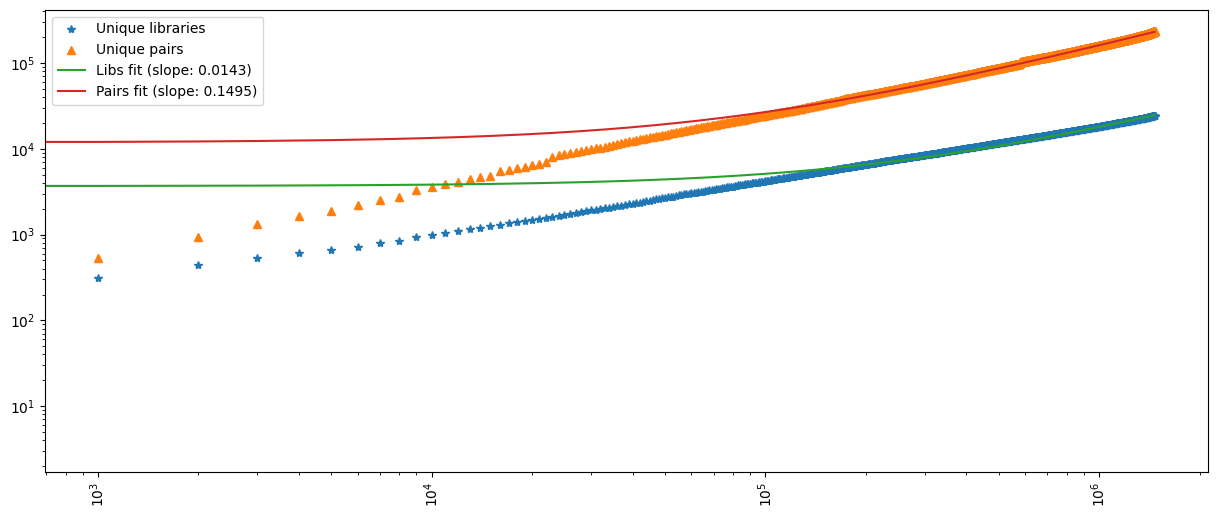

In [4]:
step_size = 1_000

plt.figure(figsize=(15,6))

plt.plot(range(0, len(xs_libs), step_size), ys_libs[::step_size], "*", label="Unique libraries")
plt.plot(range(0, len(xs_pairs), step_size), ys_pairs[::step_size], "^", label="Unique pairs")

plt.plot(range(0, len(xs_libs), step_size), [libs_a * x + libs_b for x in range(len(xs_libs))][::step_size], label=f"Libs fit (slope: {round(libs_a,4)})")
plt.plot(range(0, len(xs_pairs), step_size), [pairs_a * x + pairs_b for x in range(len(xs_pairs))][::step_size], label=f"Pairs fit (slope: {round(pairs_a, 4)})")

plt.xticks(rotation=90)
plt.legend(loc="upper left")
plt.loglog()

# Post count, lib count, pair count (y axis) against time (x axis)

In [5]:
def get_time_buckets(start, end, default_value=0):
    time_buckets = {}
    runner = datetime.datetime(*[int(item) for item in start.split("-")])
    delta = datetime.timedelta(days=1)
    while runner < datetime.datetime(*[int(item) for item in end.split("-")]):
        time_buckets[runner.strftime("%Y-%m-%d")] = default_value
        runner += delta
    return time_buckets

In [7]:
start = "2008-1-1"
end =  "2024-1-1"


xs = list(get_time_buckets(start, end).keys())

libs_buckets = get_time_buckets(start, end)
for v in libs_first_dates.values():
    libs_buckets[v["date"]] += 1
libs_ys = list(pd.Series(libs_buckets).cumsum())

pairs_buckets = get_time_buckets(start, end)
for v in pairs_first_dates.values():
    pairs_buckets[v["date"]] += 1
pairs_ys = list(pd.Series(pairs_buckets).cumsum())

post_counts_buckets =  get_time_buckets(start, end)
post_counts_buckets.update({
    k: v for k, v in daily_post_count.items() if
    datetime.datetime.strptime(start, "%Y-%m-%d") <= datetime.datetime.strptime(k, "%Y-%m-%d") < datetime.datetime.strptime(end, "%Y-%m-%d")
})
post_counts_ys = list(pd.Series(post_counts_buckets).cumsum())

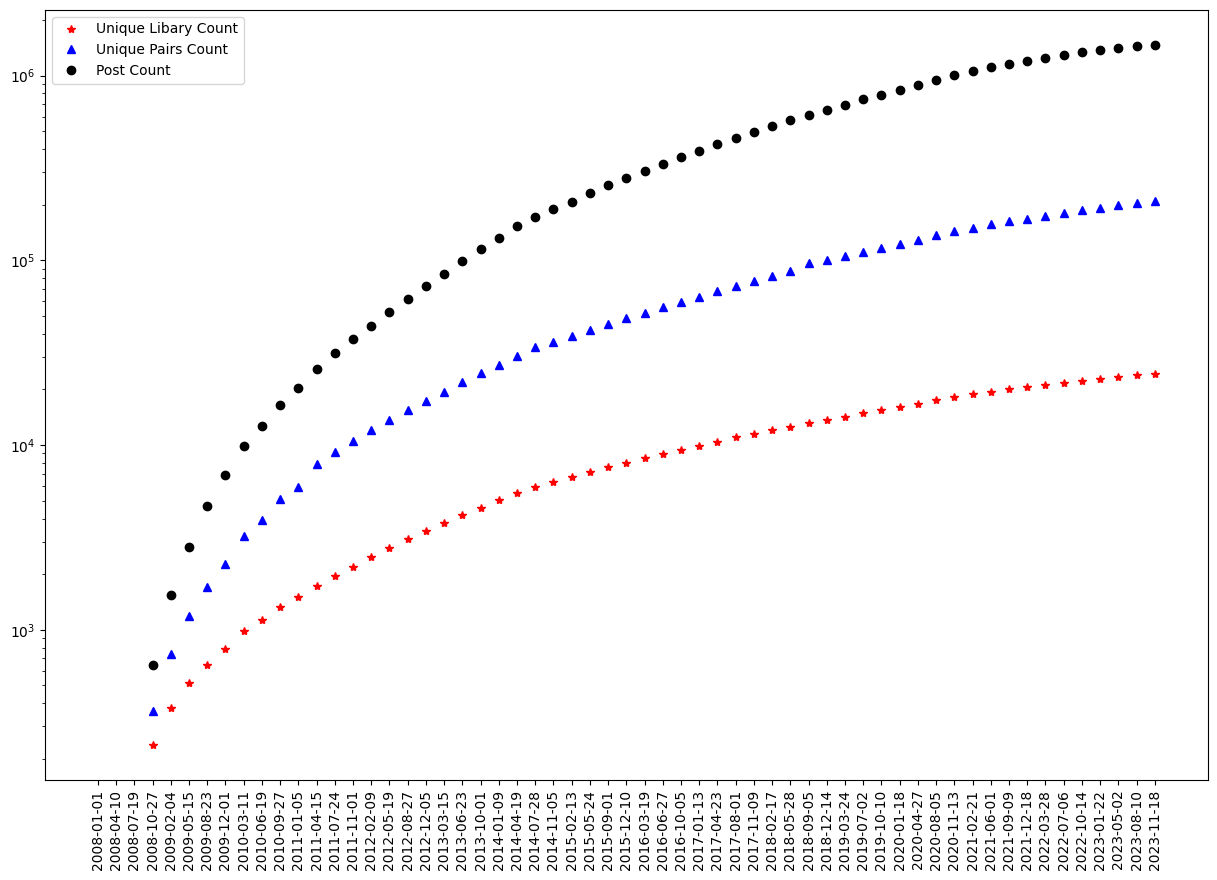

In [8]:
step_size = 100

plt.figure(figsize=(15,10))

plt.plot(xs[::step_size], libs_ys[::step_size], "r*", label="Unique Libary Count")
plt.plot(xs[::step_size], pairs_ys[::step_size], "b^", label="Unique Pairs Count")
plt.plot(xs[::step_size], post_counts_ys[::step_size], "ko", label="Post Count")

plt.xticks(rotation=90)
plt.semilogy()
plt.legend(loc="upper left")

# Frequency of libs spread across the years (x axis)

In [10]:
start = "2008-1-1"
end =  "2024-1-1"
delta = datetime.timedelta(days=365)
rolling_window = 30

xs = list(get_time_buckets(start, end))

scatters_x, scatters_y = [],  []
avg = collections.defaultdict(list)
# only checking number of uses in the year following the first appearance
for lib_name, first_appeared in tqdm.tqdm(libs_first_dates.items()):
    first_appeared_dt = datetime.datetime.strptime(first_appeared["date"], "%Y-%m-%d")
    usage_cnt = len(
        [dt for dt in all_libs_dates[lib_name]
         if first_appeared_dt <= datetime.datetime.strptime(dt, "%Y-%m-%d")  < first_appeared_dt + delta]
    )
    scatters_x.append(first_appeared_dt)
    scatters_y.append(usage_cnt)
    avg[first_appeared_dt.strftime("%Y-%m-%d")].append(usage_cnt)

df = pd.DataFrame(avg.items(), columns=['dates', 'counts'])
df['dates_dt'] = df.dates.apply(lambda dt: datetime.datetime.strptime(dt, "%Y-%m-%d"))
df['averages'] = df.counts.apply(lambda row: sum(row) / len(row))
df['roller'] = df.averages.rolling(rolling_window).mean()


100%|███████████████████████████████████| 24321/24321 [00:13<00:00, 1741.88it/s]


[]

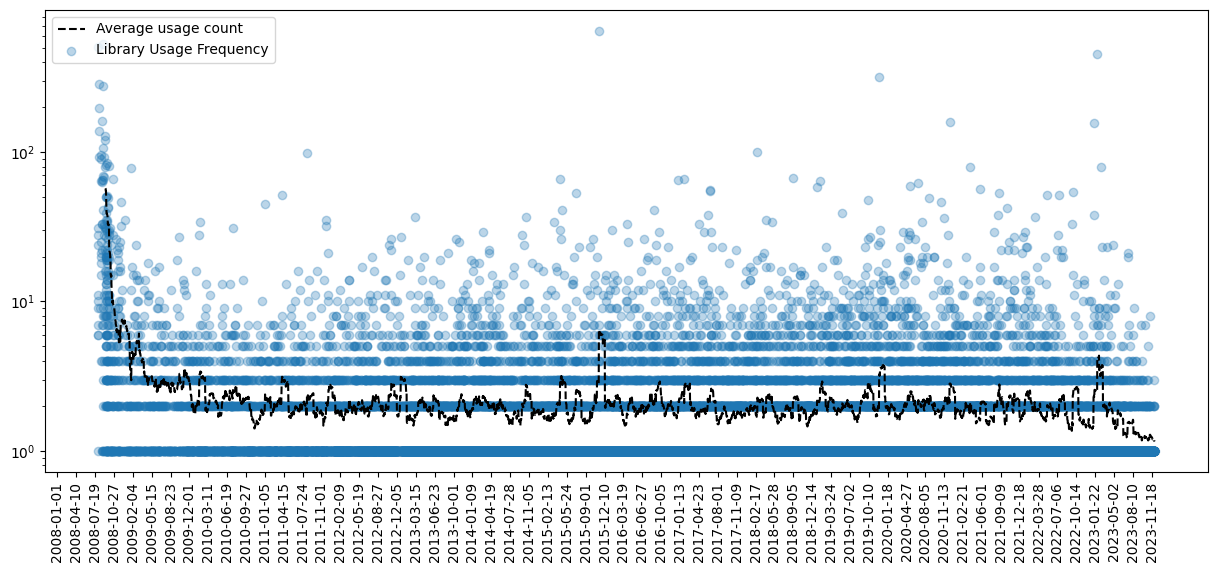

In [11]:
plt.figure(figsize=(15,6))
plt.plot(list(df.dates_dt),list(df.roller), "k--", label="Average usage count")
plt.scatter(scatters_x, scatters_y, alpha=0.3, label="Library Usage Frequency")
plt.xticks(xs[::100], rotation=90)
plt.legend(loc="upper left")
plt.semilogy()
